### Orchestrator-Worker Pattern

The orchestrator-worker pattern is ideal for complex tasks where subtasks cannot be predetermined. A central orchestrator LLM dynamically breaks down work, delegates to specialized worker LLMs, and synthesizes results.

**Key characteristics:**
- Dynamic task decomposition based on input
- Parallel execution of workers
- Centralized result synthesis

**When to use:** Tasks requiring flexible, input-dependent planning (e.g., code generation across multiple files, complex research reports).

In [1]:
# Environment setup
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [2]:
# Core imports for orchestrator-worker pattern
from typing import Annotated, List
import operator
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.constants import Send

/Users/yashsarode/Downloads/Personal Projects/Python/LangGraph-personal/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/_v/fs86q2353gvdsjh19x_1fpdm0000gn/T/ipykernel_49393/4292334374.py:10: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [3]:
# Initialize LLM using Groq
llm = ChatGroq(model="llama-3.3-70b-versatile")

# Quick test
result = llm.invoke("Hello")
print(result.content)

Hello. How can I assist you today?


### Defining Structured Output Schema

The orchestrator needs structured output to plan work distribution. We use Pydantic models to define task sections that workers will handle.

In [4]:
# Schema for orchestrator's planning output
class Task(BaseModel):
    name: str = Field(description="Name of the task")
    instructions: str = Field(description="Detailed instructions for completing this task")

class TaskPlan(BaseModel):
    tasks: List[Task] = Field(description="List of tasks to be completed")

# Create planner with structured output
planner = llm.with_structured_output(TaskPlan)

### State Management

LangGraph v1.x uses TypedDict for state management. The orchestrator state holds the overall workflow, while worker state is isolated for each parallel execution.

In [5]:
# Main workflow state
class OrchestratorState(TypedDict):
    user_request: str
    task_plan: List[Task]
    completed_tasks: Annotated[list, operator.add]  # Workers append results here
    final_output: str

# Individual worker state
class WorkerState(TypedDict):
    task: Task
    completed_tasks: Annotated[list, operator.add]

### Node Implementations

Three core nodes: orchestrator (plans), worker (executes), and synthesizer (combines results).

In [6]:
def orchestrator_node(state: OrchestratorState):
    """Breaks down the user request into discrete tasks"""
    
    task_plan = planner.invoke([
        SystemMessage(content="You are a task planning expert. Break down complex requests into clear, actionable tasks."),
        HumanMessage(content=f"User request: {state['user_request']}")
    ])
    
    print(f"\nOrchestrator created {len(task_plan.tasks)} tasks")
    return {"task_plan": task_plan.tasks}

In [7]:
def worker_node(state: WorkerState):
    """Individual worker executes assigned task"""
    
    result = llm.invoke([
        SystemMessage(content="You are a specialized worker. Complete the assigned task thoroughly and concisely."),
        HumanMessage(content=f"Task: {state['task'].name}\n\nInstructions: {state['task'].instructions}")
    ])
    
    return {"completed_tasks": [f"## {state['task'].name}\n\n{result.content}"]}

In [8]:
def synthesizer_node(state: OrchestratorState):
    """Combines all worker outputs into final deliverable"""
    
    combined_results = "\n\n---\n\n".join(state["completed_tasks"])
    
    return {"final_output": combined_results}

### Dynamic Worker Assignment with Send API

The Send API enables dynamic creation of worker nodes. Each worker gets its own isolated state while all write to a shared output channel.

In [9]:
def assign_workers(state: OrchestratorState):
    """Dynamically spawn workers for each task"""
    
    # Send creates parallel worker executions
    return [Send("worker", {"task": task}) for task in state["task_plan"]]

### Graph Construction

Build the workflow graph with proper node connections and conditional routing.

In [10]:
# Initialize graph builder
workflow = StateGraph(OrchestratorState)

# Register nodes
workflow.add_node("orchestrator", orchestrator_node)
workflow.add_node("worker", worker_node)
workflow.add_node("synthesizer", synthesizer_node)

# Define workflow edges
workflow.add_edge(START, "orchestrator")
workflow.add_conditional_edges(
    "orchestrator",
    assign_workers,
    ["worker"]
)
workflow.add_edge("worker", "synthesizer")
workflow.add_edge("synthesizer", END)

# Compile the graph
app = workflow.compile()

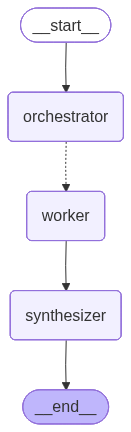

In [11]:
# Visualize the workflow
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

### Example Execution

Run the orchestrator-worker workflow with a sample request.

In [12]:
# Execute workflow
result = app.invoke({
    "user_request": "Create a technical guide on implementing RAG systems with LangChain"
})

print("\n" + "="*80)
print("FINAL OUTPUT")
print("="*80 + "\n")
print(result["final_output"])


Orchestrator created 8 tasks

FINAL OUTPUT

## Research RAG Systems

**RAG Systems Research Report**

**Introduction**

RAG (Retrieve, Augment, Generate) systems are a type of artificial intelligence (AI) architecture that combines natural language processing (NLP) and information retrieval techniques. These systems aim to improve the performance of language models by leveraging external knowledge sources and generating more accurate and informative responses.

**Components of RAG Systems**

A RAG system consists of three primary components:

1. **Retrieve**: This module is responsible for retrieving relevant information from external knowledge sources, such as databases, knowledge graphs, or text corpora. The retrieve module uses various techniques, including keyword search, entity recognition, and semantic search, to identify relevant information.
2. **Augment**: The augment module takes the retrieved information and augments it with additional context, such as entity relationships,

### Key Takeaways

**Orchestrator-Worker Pattern Advantages:**
- Dynamic task decomposition adapts to input complexity
- Parallel worker execution improves performance
- Modular design allows specialized workers

**LangGraph v1.x Features Used:**
- `Send` API for dynamic parallel node creation
- `Annotated[list, operator.add]` for shared state accumulation
- Conditional edges for flexible routing
- Structured output with `with_structured_output()`

**Production Considerations:**
- Add error handling for worker failures
- Implement retry logic for robustness
- Consider rate limiting for parallel workers
- Monitor token usage across workers